In [1]:
%matplotlib widget

In [2]:
import napari
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import tifffile
from scipy.interpolate import interp1d
from pathlib import Path
import flammkuchen as fl
from tqdm import tqdm
from scipy import ndimage
import flammkuchen as fl
import seaborn as sns
from scipy.stats import sem
from scipy.stats import zscore
import json
import imageio
from scipy import signal
from scipy.signal import medfilt, convolve, detrend
from bouter.embedded import EmbeddedExperiment
from sklearn.decomposition import PCA, FastICA
import random
from scipy.signal import savgol_filter as sgf
from sklearn.cluster import KMeans as km
from bouter.utilities import fast_pearson,fast_corrcoef
from sklearn.linear_model import SGDRegressor
from sklearn.cluster import KMeans as km
from scipy.signal import correlate as corr
from bouter.utilities import fast_pearson,fast_corrcoef, reliability
from numba import jit
from scipy.spatial.distance import euclidean
from scipy.ndimage import zoom
from matplotlib.colors import ListedColormap
from skimage import exposure
import numpy as np
from scipy import interpolate
from scipy.ndimage import gaussian_filter as gf
import matplotlib.cm as cm


In [3]:
def fill_nan(A):
    '''
    interpolate to fill nan values
    '''
    inds = np.arange(A.shape[0])
    good = np.where(np.isfinite(A))
    f = interpolate.interp1d(inds[good], A[good],bounds_error=False)
    B = np.where(np.isfinite(A),A,f(inds))
    return B
def create_bin_sphere(arr_size, center, r):
    coords = np.ogrid[:arr_size[0], :arr_size[1], :arr_size[2]]
    distance = np.sqrt((coords[0] - center[0])**2 + (coords[1]-center[1])**2 + (coords[2]-center[2])**2) 
    return 1*(distance <= r)

def normalize_traces(x_,pre=4,smooth=.3):
    out_ = np.zeros(x_.shape)
    b, a = signal.ellip(4, 0.01, 120, smooth)
    for i in range(x_.shape[0]):
        vect = fill_nan(x_[i,:])
        vect[~np.isfinite(vect)] = 0
        vect = signal.filtfilt(b, a, vect, method="gust")
        vect = vect - np.nanmedian(vect[:int(pre)])
        out_[i,:] =  vect / np.nanstd(vect)
    return out_

def get_data(path, n=0):
    behav = fl.load(list(path.glob("*beha*"))[n])
    stim = fl.load(list(path.glob("*stim*"))[n])
    with open(str(list(path.glob("*meta*"))[n])) as json_file:
        metafile = json.load(json_file)
    snapshoot = imageio.imread(list(path.glob("*img*"))[n])
    return behav, stim, metafile, np.flip(snapshoot,0)

def linear_cmap(start_,end_,n_bins=1000):
    r_ = np.interp(np.arange(n_bins),np.array([0,n_bins]),np.array([start_[0],np.clip(end_[0],0,1)]))
    g_ = np.interp(np.arange(n_bins),np.array([0,n_bins]),np.array([start_[1],np.clip(end_[1],0,1)]))
    b_ = np.interp(np.arange(n_bins),np.array([0,n_bins]),np.array([start_[-1],np.clip(end_[-1],0,1)]))
    full_ = np.stack([r_,g_,b_],-1)
    return full_

def hex_to_rgb(value):
    value = value.lstrip('#')
    lv = len(value)
    out_ = tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))
    return np.array([out_[0]/255,out_[1]/255,out_[-1]/255])

def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh) 

In [5]:
sf_AO = zoom(tifffile.imread(r"C:\Users\ge59xan\Desktop\epaoli\Desktop\CMTK_folder\210504_f1_affine_AO.tif"),(9.6,0.6,0.6))
regions_ids = fl.load(r"C:\Users\ge59xan\Desktop\epaoli\Desktop\CMTK_folder\regions_mask.h5")["array"]
list_regions = ["∅","rHb","lHb","IPN","DRN","MRN","lLOB","lROB","OT","vSp",
                "mOB","lOE","rOE","dSp","Pa","dTh","PT","PO","Cb","dHind",
               "vHind","Tor"]
list_files = [Path(r"U:\experiments\virtual_gradients_experiments\Batch_1\210504_f0"), #H2b
            Path(r"U:\experiments\virtual_gradients_experiments\Batch_1\210504_f1"), #H2b
             Path(r"U:\experiments\virtual_gradients_experiments\Batch_2\210514_f0"), #H2b
            Path(r"U:\experiments\virtual_gradients_experiments\Batch_2\210514_f1"), #H2b
            Path(r"U:\experiments\virtual_gradients_experiments\Batch_4\210607_f0")]#H2b
x_proj = imageio.imread(r"U:\experiments\virtual_gradients_experiments\figures\Imaging\projections\x_proj_png.png")
y_proj = imageio.imread(r"U:\experiments\virtual_gradients_experiments\figures\Imaging\projections\y_proj_png.png")
z_proj = imageio.imread(r"U:\experiments\virtual_gradients_experiments\figures\Imaging\projections\z_proj_png.png")

C:\Users\ge59xan\miniconda3\envs\rplab\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\ge59xan\miniconda3\envs\rplab\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  if sys.path[0] == "":
C:\Users\ge59xan\miniconda3\envs\rplab\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disapp

In [5]:
plt.rcParams.update({'font.size': 25})

# Single Fish

In [8]:
pre_bout = 2 #secs
post_bout  = 10
min_len = 10
min_bouts = 3
th_turn = 30
i_modality = 1
name_session = "temp"
radius_rois = 15

In [98]:
for i_fish in range(5):
    fish_path = list_files[i_fish]
    traces = fl.load(fish_path / "imaging" / "temp" / "traces.h5")['traces']
    to_select = np.isfinite(traces[:,0])
    ao_coordinates = fl.load(fish_path / "imaging" / "taus_analysis.h5")["coordinates"][to_select,:]
    main_path_imaging = fish_path / "imaging"
    main_path_beh = fish_path / "behavior"
    traces_to_use = zscore(traces[to_select,:],1)
    for i in range(traces_to_use.shape[0]):
        try:
            traces_to_use[i,:] = fill_nan(traces_to_use[i,:])
        except:
            pass
    traces_to_use[~np.isfinite(traces_to_use)] = 0
    traces = detrend(traces_to_use, axis=- 1, type='linear', bp=0)
    behavior , _, metadata, _ = get_data(main_path_beh/name_session)
    bouts = EmbeddedExperiment(main_path_beh/name_session).get_bout_properties()
    left = []
    right = []
    forwards = []
    for n_bout in range(len(bouts)):
        bout_idx = bouts["t_start"][n_bout].copy()
        if bout_idx > 0:
            if n_bout > 0:
                time_from_previous = (bout_idx - bouts["t_start"][n_bout-1])*2
            else:
                time_from_previous = -9999999999999999999
            if n_bout < len(bouts)-1:
                time_from_next = (bouts["t_start"][n_bout+1] - bout_idx)*2
            else:
                time_from_next = 9999999999999999999999999
            from_ = int((bout_idx-pre_bout)*2)
            to_ = int((bout_idx+post_bout)*2)
            if (from_ > 0) & (to_ <= traces.shape[1]):
                full_kernel = traces_to_use[:,from_:int((bout_idx+post_bout)*2)].copy()
                if time_from_previous < (pre_bout*2):
                    full_kernel[:,int(time_from_previous):] = np.nan
                if time_from_next < (post_bout*2):
                    full_kernel[:,-int(time_from_next):] = np.nan
                if np.isfinite(full_kernel[0,:]).sum() >= min_len:
                    to_append = normalize_traces(full_kernel)
                    if bouts["bias"][n_bout] >= np.deg2rad(th_turn):
                        right.append(to_append.copy())
                    elif bouts["bias"][n_bout] <= -np.deg2rad(th_turn):
                        left.append(to_append.copy())
                    else:
                        forwards.append(to_append.copy())

    try:
        left = np.swapaxes(np.swapaxes(np.stack(left,0),0,-1),1,2)
    except:
        left = np.zeros((24,2,traces_to_use.shape[0]))
    try:
        right = np.swapaxes(np.swapaxes(np.stack(right,0),0,-1),1,2)
    except:
        right = np.zeros((24,2,traces_to_use.shape[0]))
    try:
        forwards = np.swapaxes(np.swapaxes(np.stack(forwards,0),0,-1),1,2)
    except:
        forwards = np.zeros((24,2,traces_to_use.shape[0]))

    rel_idx_left = reliability(left)
    rel_idx_fwd = reliability(forwards)
    rel_idx_right = reliability(right)
    cont_ri = np.argmax(np.stack([rel_idx_left,rel_idx_right, rel_idx_fwd],0).T,1)
    threshold = np.percentile(np.max(np.stack([rel_idx_left,rel_idx_right,rel_idx_fwd]),0),90)
    to_take_left = (rel_idx_left>=threshold)&(cont_ri==0)&(rel_idx_right<threshold)&(rel_idx_fwd<threshold)
    to_take_right = (rel_idx_right>=threshold)&(cont_ri==1)&(rel_idx_left<threshold)&(rel_idx_fwd<threshold)
    to_take_forwards = (rel_idx_fwd>=threshold)&(cont_ri==2)&(rel_idx_left<threshold)&(rel_idx_right<threshold)
    array_btas_right = np.nanmedian(right[:,:,to_take_right],1).T
    array_btas_left = np.nanmedian(left[:,:,to_take_left],1).T
    array_btas_forwards = np.nanmedian(forwards[:,:,to_take_forwards],1).T

    selection = (np.argmax(array_btas_right[:,:],1)>4)
    order = np.argsort(np.argmax(array_btas_right[selection,:],1))
    traces_right = traces[to_take_right,:][selection,:][order,:]
    coords_right = ao_coordinates[to_take_right,:][selection,:][order,:]
    btas_right_selected = array_btas_right[selection,:][order,:]
    peak_sec_right = np.argmax(array_btas_right[selection,:],1) / 2
    right_dict = {"traces":traces_right,
                  "coord": coords_right,
                 "btas":btas_right_selected,
                 "peak":peak_sec_right}
    selection = (np.argmax(array_btas_left[:,:],1)>4
    order = np.argsort(np.argmax(array_btas_left[selection,:],1))
    traces_left = traces[to_take_left,:][selection,:][order,:]
    coords_left = ao_coordinates[to_take_left,:][selection,:][order,:]

    btas_left_selected = array_btas_left[selection,:][order,:]
    peak_sec_left = np.argmax(array_btas_left[selection,:],1) / 2
    left_dict = {"traces":traces_left,
                 "coord":coords_left,
                 "btas":btas_left_selected,
                 "peak":peak_sec_left}
    selection = (np.argmax(array_btas_forwards[:,:],1)>4)
    order = np.argsort(np.argmax(array_btas_forwards[selection,:],1))
    traces_forwards = traces[to_take_forwards,:][selection,:][order,:]
    coords_forwards = ao_coordinates[to_take_forwards,:][selection,:][order,:]
    btas_forwards_selected = array_btas_forwards[selection,:][order,:]
    peak_sec_forwards = np.argmax(array_btas_forwards[selection,:],1) / 2
    forwards_dict = {"traces":traces_forwards,
                    "coord":coords_forwards,
                "btas":btas_forwards_selected,
                "peak":peak_sec_forwards}
    dict_res = {"left":left_dict,
               "right":right_dict,
               "threshold":np.percentile(np.max(np.stack([rel_idx_left,rel_idx_right]),0),90),
              "forward":forwards_dict}

#     fl.save(fish_path / "imaging" / "temp" / "simple_bta_v01.h5",dict_res)

### Load all fish

In [6]:
name_session = "temp"
pool_l_coords = []
pool_l_btas = []
pool_l_full_traces = []
pool_r_full_traces = []
pool_r_coords = []
pool_r_btas = []

pool_f_coords = []
pool_f_btas = []
pool_f_full_traces = []

behaviours = []
for i in range(5):
    try:
        fish_path = list_files[i]
        main_path_beh = fish_path / "behavior"

        behavior , _, metadata, _ = get_data(main_path_beh/name_session)
        behaviours.append(behavior)
        #bouts = EmbeddedExperiment(main_path_beh/name_session).get_bout_properties()
        dict_res = fl.load(fish_path / "imaging" / "temp" / "simple_bta_v01.h5")
        pool_l_coords.append(dict_res["left"]["coord"])
        pool_r_coords.append(dict_res["right"]["coord"])
        pool_l_btas.append(dict_res["left"]["btas"])
        pool_r_btas.append(dict_res["right"]["btas"])
        pool_l_full_traces.append(dict_res["left"]["traces"])
        pool_r_full_traces.append(dict_res["right"]["traces"])
        pool_f_coords.append(dict_res["forward"]["coord"])
        pool_f_btas.append(dict_res["forward"]["btas"])
        pool_f_full_traces.append(dict_res["forward"]["traces"])


    except:
        print(i)

C:\Users\ge59xan\miniconda3\envs\rplab\lib\site-packages\ipykernel_launcher.py:31: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.


In [9]:
bins_ = [np.concatenate(pool_l_coords,0)[:,:-1],
         np.concatenate(pool_f_coords,0)[:,:-1],
         np.concatenate(pool_r_coords,0)[:,:-1],
        np.concatenate([np.concatenate(pool_l_coords,0),
                        np.concatenate(pool_f_coords,0),
                        np.concatenate(pool_r_coords,0)],0)[:,:-1]
        ]
volumes = []
for coords in bins_:
    volume_ = np.zeros(sf_AO.shape)
    for i in tqdm(range(coords.shape[0])):
        volume_+=create_bin_sphere(sf_AO.shape, (coords[i,0]*9.6,coords[i,1]*.6,
                                      coords[i,2]*.6), radius_rois)
    volumes.append(volume_)
# fl.save(r"U:\Shared\experiments\virtual_gradients_experiments\volume_array_simple_motor_average_lfra.h5",{"array":volumes})

  2%|█▎                                                                          | 344/19278 [02:39<2:26:12,  2.16it/s]


KeyboardInterrupt: 

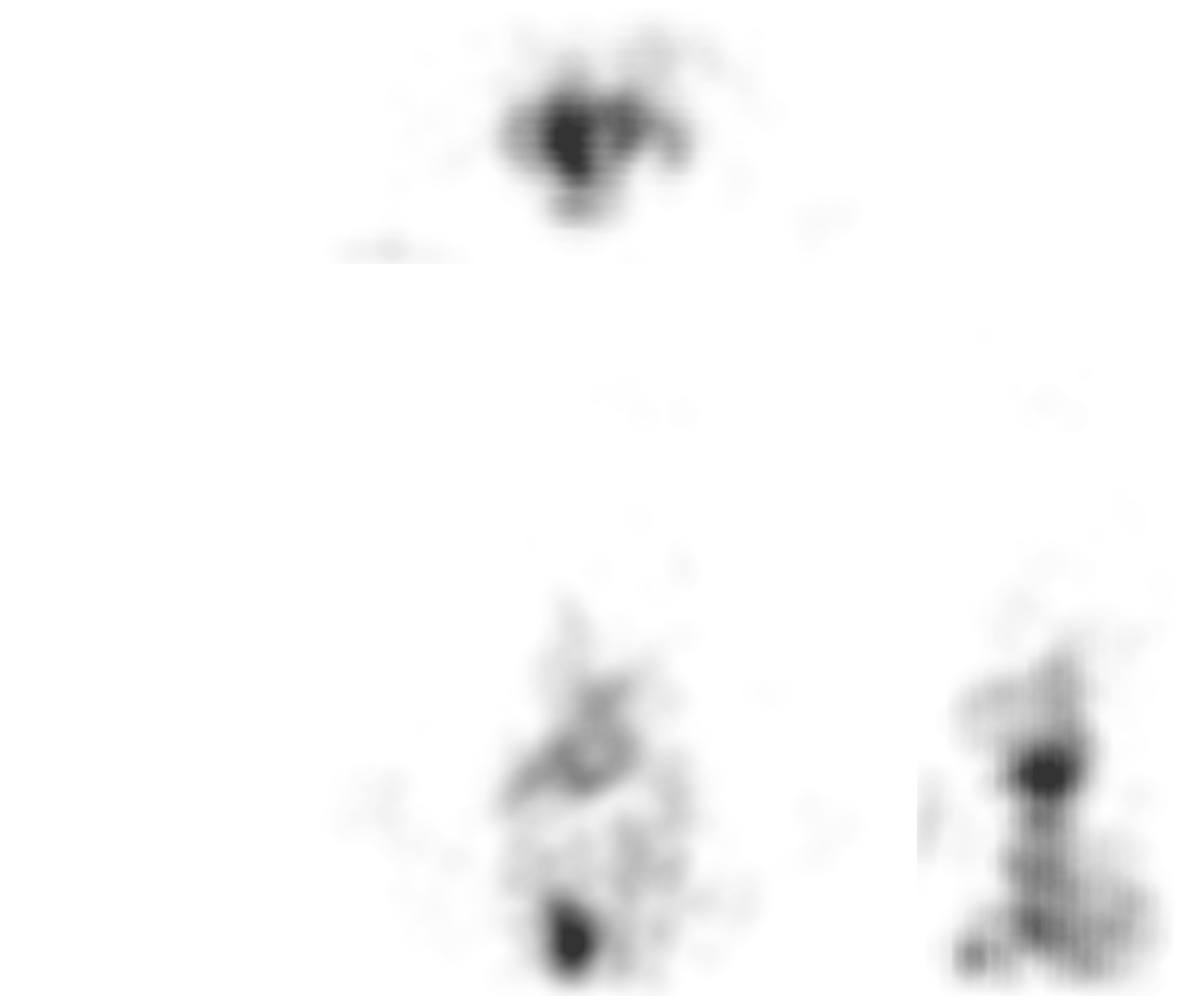

In [49]:
cmap_ref = ListedColormap(cm.get_cmap('gray')(np.linspace(0,1,1000))[:500,:])
color_array = plt.cm.afmhot(np.linspace(0,1,1000))
color_array = ListedColormap(color_array[:,:])
volume = volumes[0].copy()
vmin = 0
vmax=.9
cmap_ = "gray_r"
fig = plt.figure(figsize=(12, 10),constrained_layout=True)
gs = fig.add_gridspec(nrows=3, ncols=3, width_ratios=[1,2,1], height_ratios=[.72,1,1])
ax1 = fig.add_subplot(gs[0,1]) 
ax1.imshow(np.flip(volume.sum(1),0),cmap=cmap_,
           alpha=.8,vmin=vmin*np.nanmax(volume.sum(1)), vmax=vmax*np.nanmax(volume.sum(1)))
ax1.set_xticks([])
ax1.set_yticks([])

ax2 = fig.add_subplot(gs[1:,1])
ax2.imshow(gf(np.roll(volume[:,:,:].sum(0),0),1),cmap=cmap_,
           alpha=.8,vmin=vmin*np.nanmax(volume.sum(0)), vmax=vmax*np.nanmax(volume[:,:,:].sum(0)))
ax2.set_xticks([])
ax2.set_yticks([])

ax3 = fig.add_subplot(gs[1:,-1]) 

ax3.imshow(np.rot90(np.flip(volume.sum(2),0),-1),cmap=cmap_,
           alpha=.8,vmin=vmin*np.nanmax(volume.sum(2)), vmax=vmax*np.nanmax(volume.sum(2)))
ax3.set_xticks([])
ax3.set_yticks([])


sns.despine(bottom=True,left=True)
plt.savefig(r"C:\Users\ge59xan\Desktop\new_left_neurons.png",dpi=800)
plt.show()

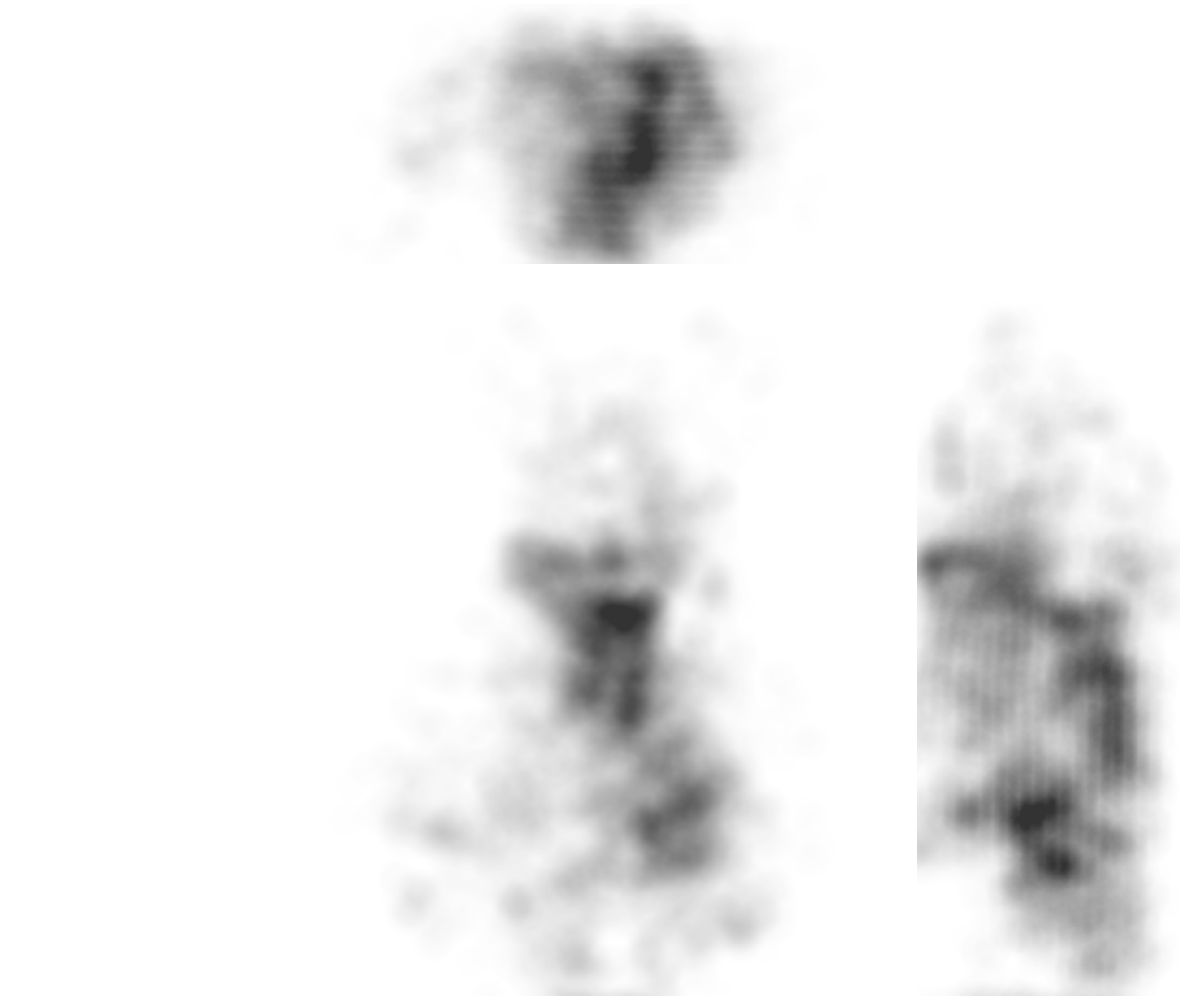

In [53]:
cmap_ref = ListedColormap(cm.get_cmap('gray')(np.linspace(0,1,1000))[:500,:])
color_array = plt.cm.afmhot(np.linspace(0,1,1000))
color_array = ListedColormap(color_array[:,:])
volume = volumes[1].copy()
vmin = 0
vmax= .9
cmap_ = "gray_r"
fig = plt.figure(figsize=(12, 10),constrained_layout=True)
gs = fig.add_gridspec(nrows=3, ncols=3, width_ratios=[1,2,1], height_ratios=[.72,1,1])
ax1 = fig.add_subplot(gs[0,1]) 
ax1.imshow(np.flip(volume.sum(1),0),cmap=cmap_,
           alpha=.8,vmin=vmin*np.nanmax(volume.sum(1)), vmax=vmax*np.nanmax(volume.sum(1)))
ax1.set_xticks([])
ax1.set_yticks([])

ax2 = fig.add_subplot(gs[1:,1])
ax2.imshow(gf(np.roll(volume[:,:,:].sum(0),0),1),cmap=cmap_,
           alpha=.8,vmin=vmin*np.nanmax(volume.sum(0)), vmax=vmax*np.nanmax(volume[:,:,:].sum(0)))
ax2.set_xticks([])
ax2.set_yticks([])

ax3 = fig.add_subplot(gs[1:,-1]) 

ax3.imshow(np.rot90(np.flip(volume.sum(2),0),-1),cmap=cmap_,
           alpha=.8,vmin=vmin*np.nanmax(volume.sum(2)), vmax=vmax*np.nanmax(volume.sum(2)))
ax3.set_xticks([])
ax3.set_yticks([])


sns.despine(bottom=True,left=True)
plt.savefig(r"C:\Users\ge59xan\Desktop\new_forward_neurons.png",dpi=800)
plt.show()

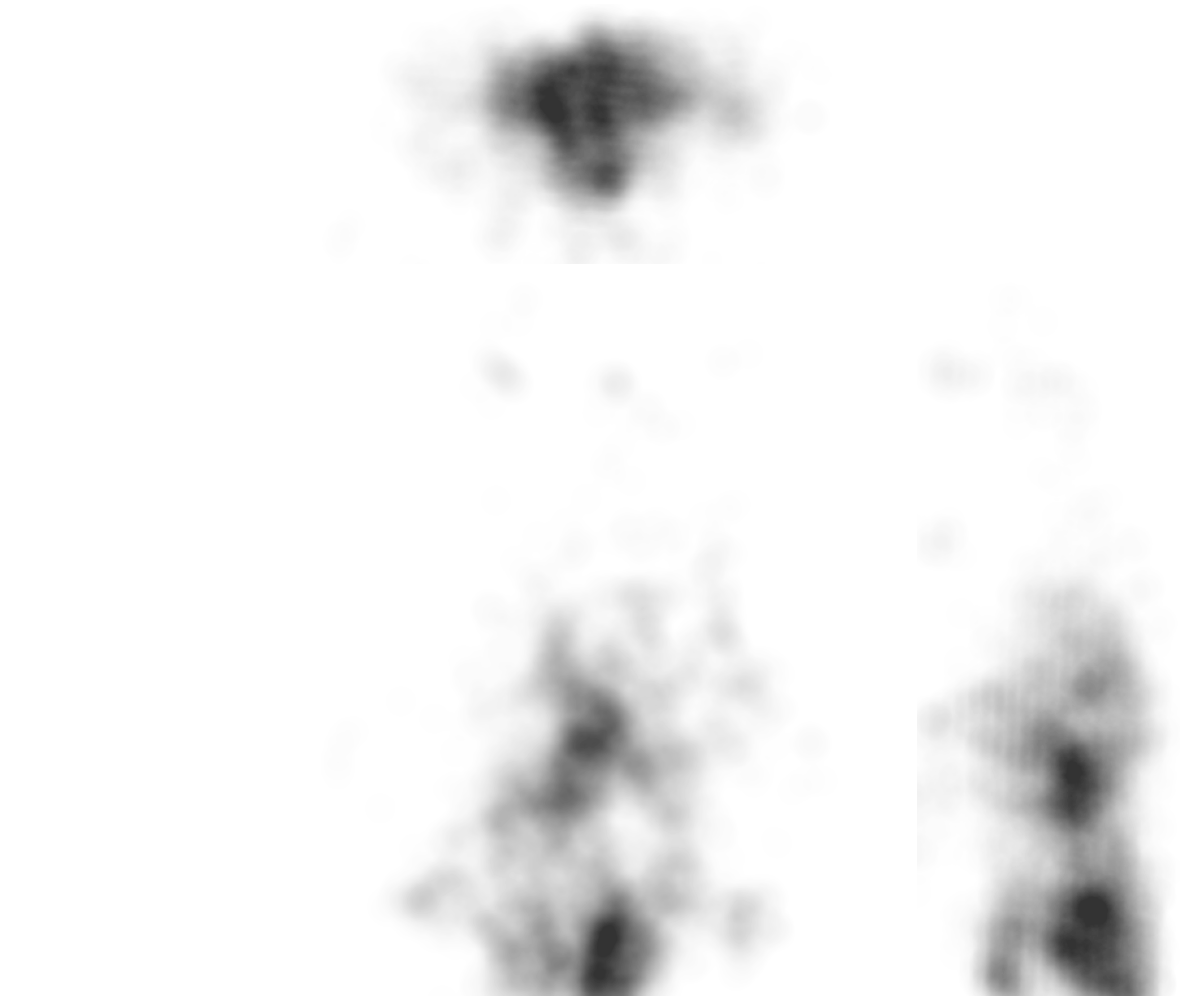

In [52]:
cmap_ref = ListedColormap(cm.get_cmap('gray')(np.linspace(0,1,1000))[:500,:])
color_array = plt.cm.afmhot(np.linspace(0,1,1000))
color_array = ListedColormap(color_array[:,:])
volume = volumes[2].copy()
vmin = 0
vmax=.9
cmap_ = "gray_r"
fig = plt.figure(figsize=(12, 10),constrained_layout=True)
gs = fig.add_gridspec(nrows=3, ncols=3, width_ratios=[1,2,1], height_ratios=[.72,1,1])
ax1 = fig.add_subplot(gs[0,1]) 
ax1.imshow(np.flip(volume.sum(1),0),cmap=cmap_,
           alpha=.8,vmin=vmin*np.nanmax(volume.sum(1)), vmax=vmax*np.nanmax(volume.sum(1)))
ax1.set_xticks([])
ax1.set_yticks([])

ax2 = fig.add_subplot(gs[1:,1])
ax2.imshow(gf(np.roll(volume[:,:,:].sum(0),0),1),cmap=cmap_,
           alpha=.8,vmin=vmin*np.nanmax(volume.sum(0)), vmax=vmax*np.nanmax(volume[:,:,:].sum(0)))
ax2.set_xticks([])
ax2.set_yticks([])

ax3 = fig.add_subplot(gs[1:,-1]) 

ax3.imshow(np.rot90(np.flip(volume.sum(2),0),-1),cmap=cmap_,
           alpha=.8,vmin=vmin*np.nanmax(volume.sum(2)), vmax=vmax*np.nanmax(volume.sum(2)))
ax3.set_xticks([])
ax3.set_yticks([])


sns.despine(bottom=True,left=True)
plt.savefig(r"C:\Users\ge59xan\Desktop\new_right_neurons.png",dpi=800)
plt.show()

In [34]:
# %%time
# radius_rois = 20
# volume_fast = np.zeros(sf_AO.shape)
# for i in tqdm(range(coords_fast.shape[0])):
#     volume_fast+=create_bin_sphere(sf_AO.shape, (coords_fast[i,0]*9.6,coords_fast[i,1]*.6,
#                                   coords_fast[i,2]*.6), radius_rois)
# volume_slow = np.zeros(sf_AO.shape)
# for i in tqdm(range(coords_slow.shape[0])):
#     volume_slow+=create_bin_sphere(sf_AO.shape, (coords_slow[i,0]*9.6,coords_slow[i,1]*.6,
#                                   coords_slow[i,2]*.6), radius_rois)

In [24]:
bins_ = [np.concatenate([np.concatenate(pool_l_coords,0),
                        np.concatenate(pool_r_coords,0)],0)[:,:-1]]
for coords in bins_:
    volume_ = np.zeros(sf_AO.shape)
    for i in tqdm(range(coords.shape[0])):
        volume_+=create_bin_sphere(sf_AO.shape, (coords[i,0]*9.6,coords[i,1]*.6,
                                      coords[i,2]*.6), radius_rois)
    volumes.append(volume_)

100%|██████████████████████████████████████████████████████████████████████████| 11524/11524 [1:32:40<00:00,  2.07it/s]


## All motors

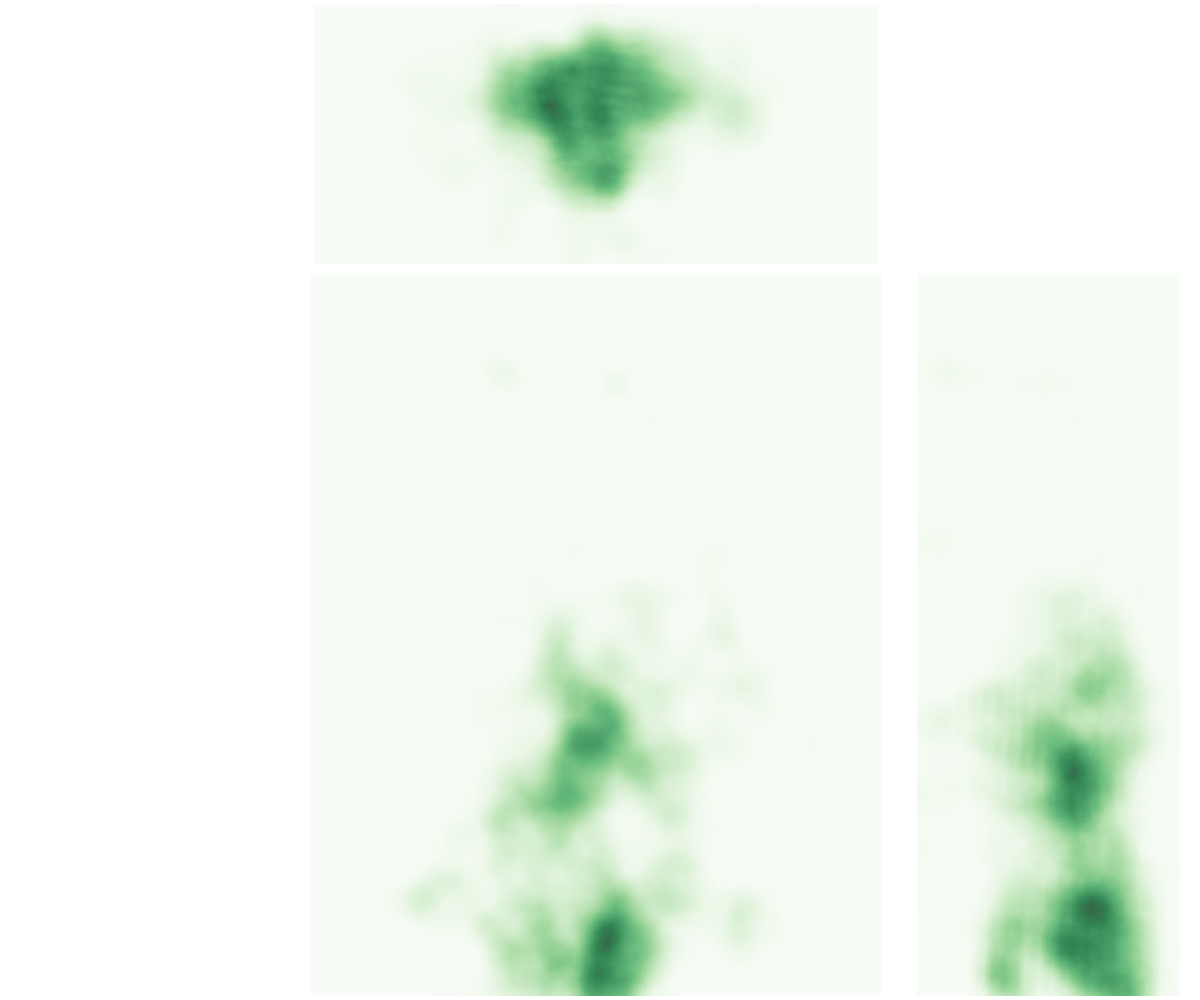

In [23]:
cmap_ref = ListedColormap(cm.get_cmap('gray')(np.linspace(0,1,1000))[:500,:])
color_array = plt.cm.afmhot(np.linspace(0,1,1000))
color_array = ListedColormap(color_array[:800,:])
volume = volumes[-2].copy()
vmin = None
vmax=1
fig = plt.figure(figsize=(12, 10),constrained_layout=True)
gs = fig.add_gridspec(nrows=3, ncols=3, width_ratios=[1,2,1], height_ratios=[.72,1,1])
ax1 = fig.add_subplot(gs[0,1]) 
ax1.imshow(np.flip(volume.sum(1),0),cmap="Greens",
           alpha=.8,vmin=vmin, vmax=vmax*np.nanmax(volume.sum(1)))
ax1.set_xticks([])
ax1.set_yticks([])

ax2 = fig.add_subplot(gs[1:,1])
ax2.imshow(gf(np.roll(volume[:,:,:].sum(0),0),1),cmap="Greens",
           alpha=.8,vmin=vmin, vmax=vmax*np.nanmax(volume[:,:,:].sum(0)))
ax2.set_xticks([])
ax2.set_yticks([])

ax3 = fig.add_subplot(gs[1:,-1]) 

ax3.imshow(np.rot90(np.flip(volume.sum(2),0),-1),cmap="Greens",
           alpha=.8,vmin=vmin, vmax=vmax*np.nanmax(volume.sum(2)))
ax3.set_xticks([])
ax3.set_yticks([])
sns.despine(bottom=True,left=True)
plt.show()

In [7]:
full_coords = np.concatenate([np.concatenate(pool_l_coords,0),np.concatenate(pool_f_coords,0),np.concatenate(pool_r_coords,0)],0)[:,:-1]
region_id = np.zeros((full_coords.shape[0],1))
for i_roi in range(full_coords.shape[0]):

    x = int(full_coords[i_roi,0])
    y = int(full_coords[i_roi,1])
    z = int(full_coords[i_roi,2])
    try:
        id_region = regions_ids[x,y,z]
    except:
        id_region = np.nan
    region_id[i_roi,:] = id_region

In [8]:
whole_brain_coords = []
for fish_path in list_files[:5]:
    traces = fl.load(fish_path / "imaging" / "temp" / "traces.h5")['traces']
    to_select = np.isfinite(traces[:,0])
    ao_coordinates = fl.load(fish_path / "imaging" / "taus_analysis.h5")["coordinates"][to_select,:]
    whole_brain_coords.append(ao_coordinates)
whole_brain_coords = np.concatenate(whole_brain_coords,0)

In [18]:
whole_brain_coords.shape

(223862, 4)

In [9]:
target_regions = [[6,7,10],[9,13,14],[1,2],[17],[3,4,5],[19,20]]

In [10]:
list_regions = ["rHb","lHb","IPN","DRN","MRN","lLOB","lROB","OT","vSp",
                "mOB","lOE","rOE","dSp","Pa","dTh","PT","PO","Cb","dHind",
               "vHind","Tor"]

In [11]:
percentages = []
for reg_id in target_regions:

    counts_motor = 0
    counts_all = 0
    for single_region in reg_id:
        counts_motor += np.sum(region_id==single_region)
        counts_all += np.sum(whole_brain_coords[:,-1]==single_region)
    perc_ = counts_motor / counts_all
    percentages.append(perc_)

In [12]:
percentages = np.stack(percentages)

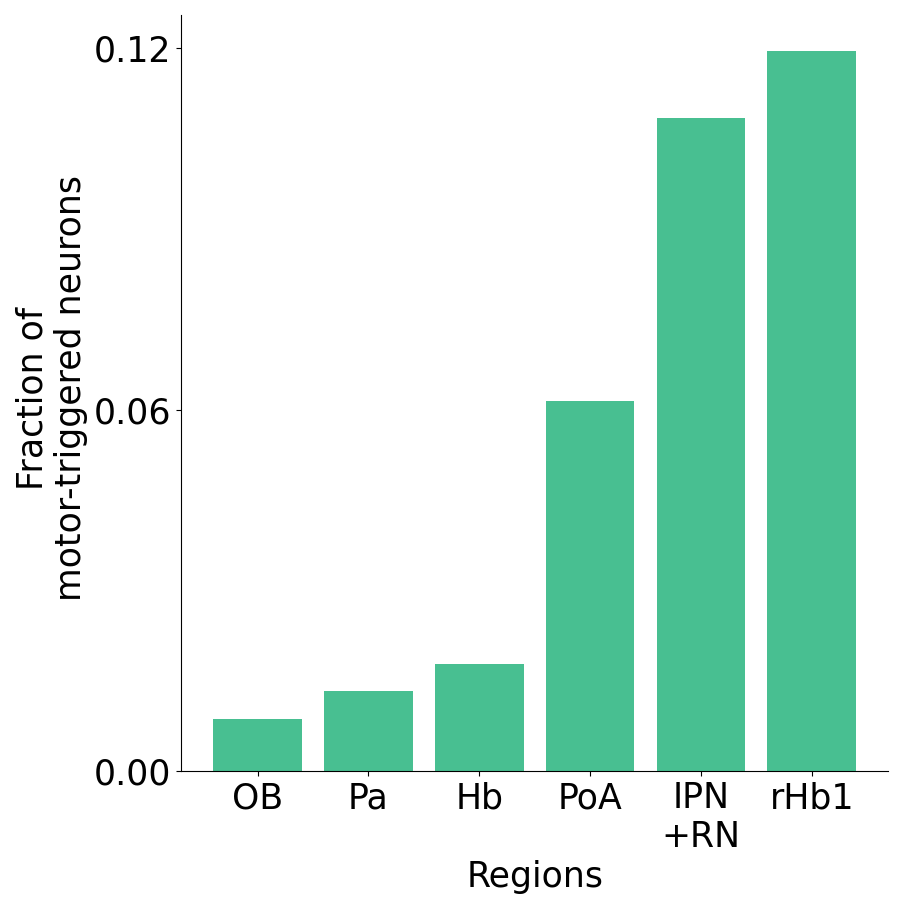

In [15]:
plt.figure()
plt.bar(np.arange(6),percentages[:],color="#48BF91")
plt.xticks(np.arange(6),["OB","Pa","Hb","PoA","IPN\n+RN","rHb1"],fontsize=25)
plt.yticks([0,.06,.12],fontsize=25)
plt.ylabel("Fraction of \n motor-triggered neurons",fontsize=25)
plt.xlabel("Regions",fontsize=25)
sns.despine()
set_size(7,7)
plt.tight_layout()

plt.show()
plt.savefig(r"C:\Users\ge59xan\Desktop\4_b_newnewnew.png",dpi=800)
# plt.savefig(r"C:\Users\ge59xan\Desktop\new_figs_new\4_b_new.pdf",dpi=800)

### Turn tuned neurons with different timescales

In [62]:
from scipy.optimize import curve_fit

In [165]:
def double_exp(x, tau0,tau1):
    out = +(+np.exp(-tau1 * x))-(+np.exp(-tau0 * x))
    return out

def line(x, m):
    out = m*x
    return out

In [72]:
x = np.linspace(0,turn_btas.shape[1]/2,turn_btas.shape[1])

In [173]:
n_ = 1

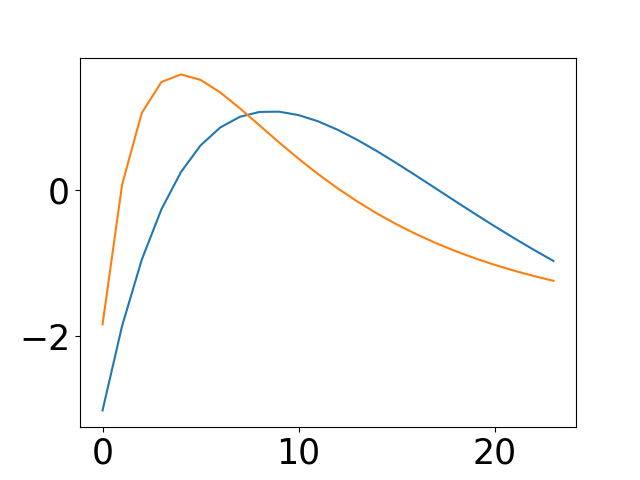

In [268]:
plt.figure()
plt.plot(zscore(double_exp(x, .25,.2)))
plt.plot(zscore(double_exp(x, .95,.2)))
plt.show()

In [290]:
lab = km(4).fit(turn_btas).labels_

C:\Users\ge59xan\miniconda3\envs\rplab\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until


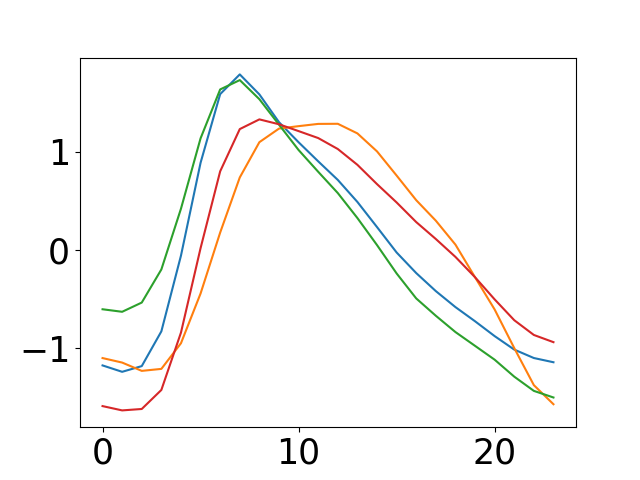

In [291]:
plt.figure()
for i in range(5):
    plt.plot(zscore(np.nanmean(turn_btas[lab==i,:],0)))
plt.show()

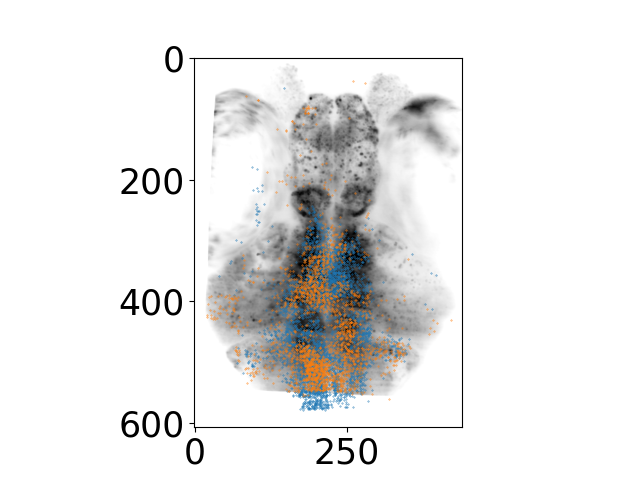

In [292]:
order = np.argsort(abs(values))
# np.random.shuffle(order)
plt.figure()
plt.imshow(sf_AO.max(0),cmap="gray_r")
plt.scatter(turn_coords[lab==0,2]*.6,turn_coords[lab==0,1]*.6,s=.1)

plt.scatter(turn_coords[lab==1,2]*.6,turn_coords[lab==1,1]*.6,s=.1)
plt.show()

In [179]:
popt, pcov = curve_fit(line, x[np.where(abs(turn_btas[n_,:])>.3)[0][0]:np.argmax(abs(turn_btas[n_,:]))],
                       turn_btas[n_,np.where(abs(turn_btas[n_,:])>.3)[0][0]:np.argmax(abs(turn_btas[n_,:]))],
                       bounds=([-1], [1]))

In [300]:
values = []
for n_ in range(turn_btas.shape[0]):
    popt, pcov = curve_fit(line, x[np.where(abs(turn_btas[n_,:])>.2)[0][0]:np.argmax(abs(turn_btas[n_,:]))],
                           turn_btas[n_,np.where(abs(turn_btas[n_,:])>.2)[0][0]:np.argmax(abs(turn_btas[n_,:]))],
                           bounds=([-1], [10]))
    values.append(popt[0])
values = np.array(values)

In [294]:
# values = []
# for n_ in range(turn_btas.shape[0]):
#     c = abs(fast_pearson(zscore(turn_btas[n_,:]),zscore(double_exp(x, .25,.2))))-abs(fast_pearson(zscore(turn_btas[n_,:]),zscore(double_exp(x, .95,.2))))
#     values.append(c)
# values = np.array(values)

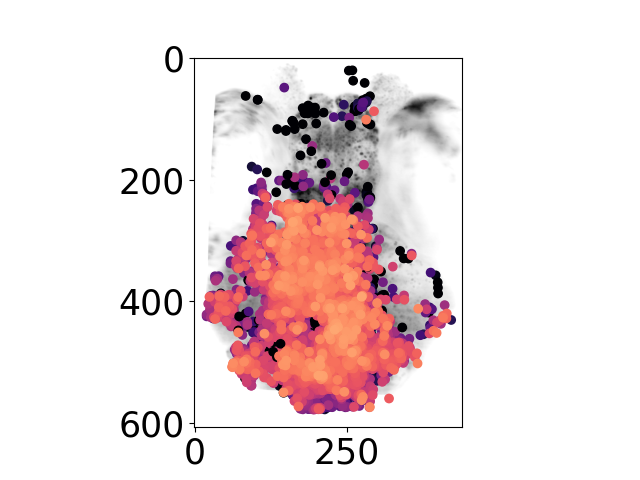

In [277]:
order = np.argsort(abs(values))
# np.random.shuffle(order)
plt.figure()
plt.imshow(sf_AO.max(0),cmap="gray_r")
plt.scatter(turn_coords[order,2]*.6,turn_coords[order,1]*.6,c=values[order],vmin=0,vmax=1,cmap="magma")
plt.show()

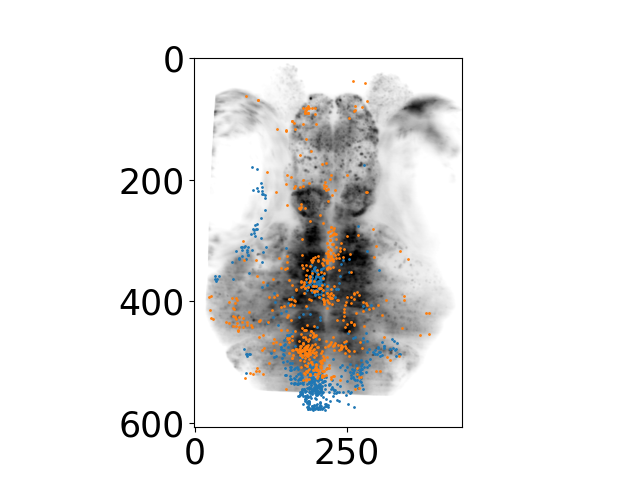

In [323]:
first_selection = values>0
to_select = abs(values[first_selection]) > np.percentile(abs(values[first_selection]),95)
plt.figure()
plt.imshow(sf_AO.max(0),cmap="gray_r")
plt.scatter(turn_coords[first_selection][to_select,2]*.6,turn_coords[first_selection][to_select,1]*.6,cmap="afmhot_r",s=1)
to_select = values[first_selection] < np.percentile(abs(values[first_selection]),5)
plt.scatter(turn_coords[first_selection][to_select,2]*.6,turn_coords[first_selection][to_select,1]*.6,cmap="afmhot_r",s=1)
plt.show()

In [325]:
volume_slow = np.zeros(sf_AO.shape)
first_selection = values>0
to_select = abs(values[first_selection]) > np.percentile(abs(values[first_selection]),95)
coords = turn_coords[first_selection][to_select,:]
for i in tqdm(range(coords.shape[0])):
    volume_slow+=create_bin_sphere(sf_AO.shape, (coords[i,0]*9.6,coords[i,1]*.6,
                                  coords[i,2]*.6), radius_rois)

volume_fast = np.zeros(sf_AO.shape)
first_selection = values>0
to_select = abs(values[first_selection]) < np.percentile(abs(values[first_selection]),5)
coords = turn_coords[first_selection][to_select,:]
for i in tqdm(range(coords.shape[0])):
    volume_fast+=create_bin_sphere(sf_AO.shape, (coords[i,0]*9.6,coords[i,1]*.6,
                                  coords[i,2]*.6), radius_rois)

100%|████████████████████████████████████████████████████████████████████████████████| 571/571 [04:25<00:00,  2.15it/s]


In [337]:
volume_diff = volume_fast - volume_slow

In [331]:
vmax

2.8090170981040285e-06

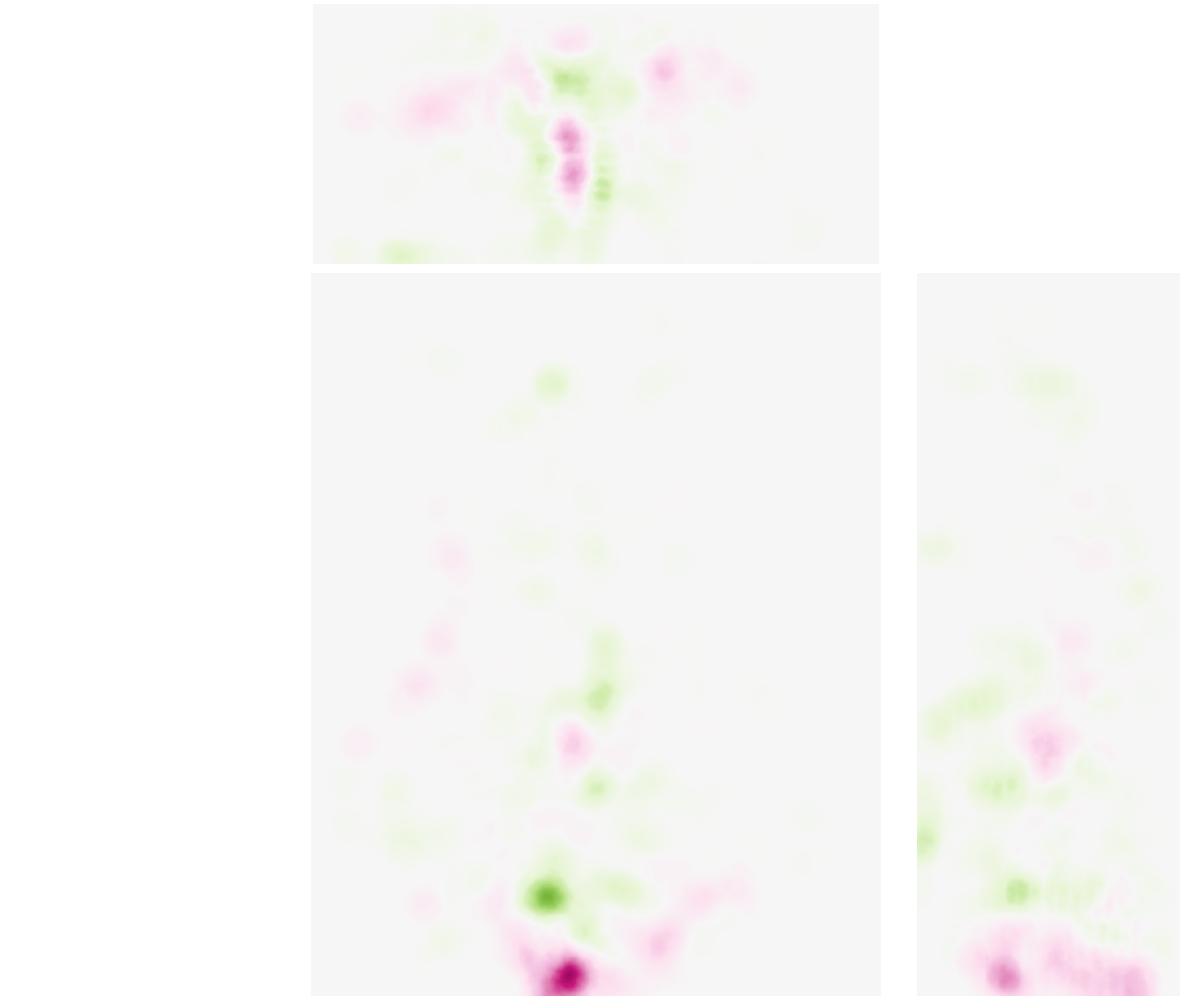

In [341]:
vmin = -2000#-0.0003
vmax = 2000#0.0003
volume = volume_diff.copy()

fig = plt.figure(figsize=(12, 10),constrained_layout=True)
gs = fig.add_gridspec(nrows=3, ncols=3, width_ratios=[1,2,1], height_ratios=[.72,1,1])
ax1 = fig.add_subplot(gs[0,1])
ax1.imshow(np.flip(volume.sum(1),0),cmap="PiYG",alpha=1,
           vmin=vmin,
           vmax=vmax)

ax1.set_xticks([])
ax1.set_yticks([])

ax2 = fig.add_subplot(gs[1:,1])

ax2.imshow(volume[:,:,:].sum(0),cmap="PiYG",alpha=1,
           vmin=vmin,
           vmax=vmax)
ax2.set_xticks([])
ax2.set_yticks([])

ax3 = fig.add_subplot(gs[1:,2:])

ax3.imshow(np.rot90(np.flip(volume.sum(2),0),-1),cmap="PiYG",alpha=1,
           vmin=vmin,
           vmax=vmax)
ax3.set_xticks([])
ax3.set_yticks([])
sns.despine(left=True,bottom=True)
plt.show()
# plt.savefig(r"C:\Users\epaoli\Desktop\new_figs\1_e.png",dpi=800)

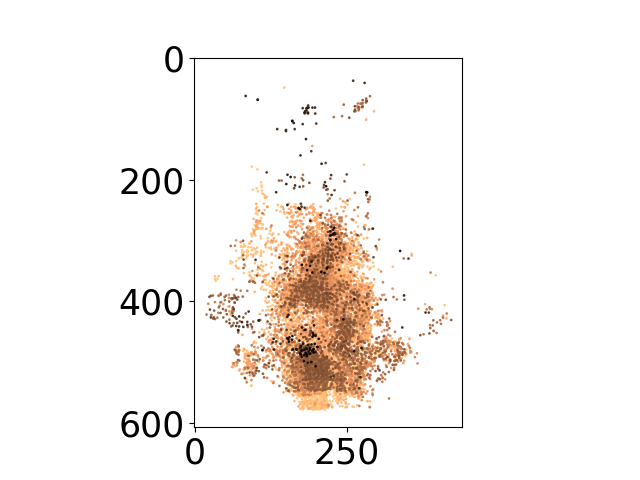

In [310]:
select = values > 0
order = np.argsort(-abs(values[select]))
# np.random.shuffle(order)
plt.figure()
plt.imshow(sf_AO.max(0),cmap="gray_r", alpha=0)
plt.scatter(turn_coords[select][order,2]*.6,turn_coords[select][order,1]*.6,
            c=values[select][order],cmap="copper",s=.9,alpha=.9,vmin=0,vmax=.7)
# plt.ylim([sf_AO.max(0).shape[1],0])
# plt.xlim([0,sf_AO.max(0).shape[0]])
plt.show()

In [313]:
np.percentile(values[select],95)

0.7632239585984184

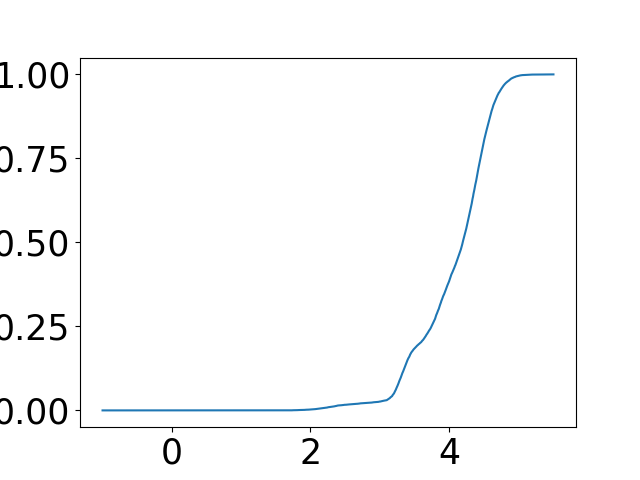

In [342]:
plt.figure()
c,_ = np.histogram(values, np.linspace(-1,1,1000))
bins_plot = (np.linspace(-1,1,1000)[:-1]+np.linspace(-1,10,1000)[1:])/2
c = np.cumsum(c / np.sum(c))
plt.plot(bins_plot,c)
plt.show()

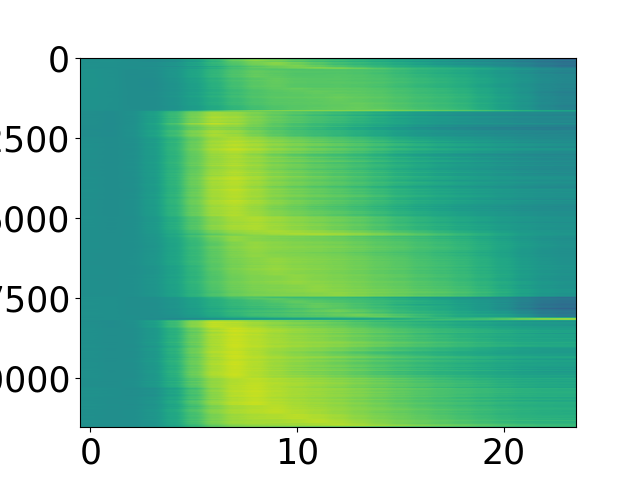

In [57]:
plt.figure()
plt.imshow(turn_btas,aspect="auto")
plt.show()

In [99]:
bins_ = np.array([np.percentile(np.argmax(turn_btas,1),0),
                  np.percentile(np.argmax(turn_btas,1),25),
                  np.percentile(np.argmax(turn_btas,1),50),
                  np.percentile(np.argmax(turn_btas,1),75),
                 np.percentile(np.argmax(turn_btas,1),100)])
radius_rois = 15
# primary_colors = ["#e9311a","#ed6335","#026c80","#064c82"]
vmin = None
vmax=None

In [55]:
pool_l_coords = np.concatenate(pool_l_coords,0)
pool_r_coords = np.concatenate(pool_r_coords,0)
pool_l_btas = np.concatenate(pool_l_btas,0)
pool_r_btas = np.concatenate(pool_r_btas,0)
flip_r_coords = pool_r_coords.copy()
flip_r_coords[:,2] = abs(flip_r_coords[:,2] - 700)
turn_coords = np.concatenate([pool_l_coords,flip_r_coords],0)
turn_btas = np.concatenate([pool_l_btas,pool_r_btas],0)

In [101]:
volumes = []
for s_,e_ in zip(bins_[:-1],bins_[1:]):
    volume_ = np.zeros(sf_AO.shape)
    to_take = (np.argmax(turn_btas,1)>=s_)&(np.argmax(turn_btas,1)<e_)
    coords = turn_coords[to_take,:]
    for i in tqdm(range(coords.shape[0])):
        volume_+=create_bin_sphere(sf_AO.shape, (coords[i,0]*9.6,coords[i,1]*.6,
                                      coords[i,2]*.6), radius_rois)
    volumes.append(volume_)

100%|██████████████████████████████████████████████████████████████████████████████| 3961/3961 [44:51<00:00,  1.47it/s]


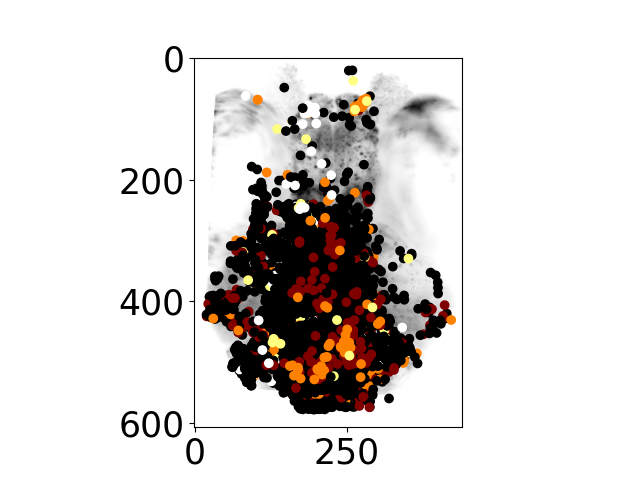

In [94]:
order = np.argsort(np.argmax(turn_btas,1))
plt.figure()
plt.imshow(sf_AO.max(0),cmap="gray_r")
plt.scatter(turn_coords[order,2]*.6,turn_coords[order,1]*.6,c=np.argmax(turn_btas,1),vmin=10,vmax=14,cmap="afmhot")
plt.show()

C:\Users\epaoli\anaconda3\lib\site-packages\ipykernel_launcher.py:2: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("gray").copy()
  


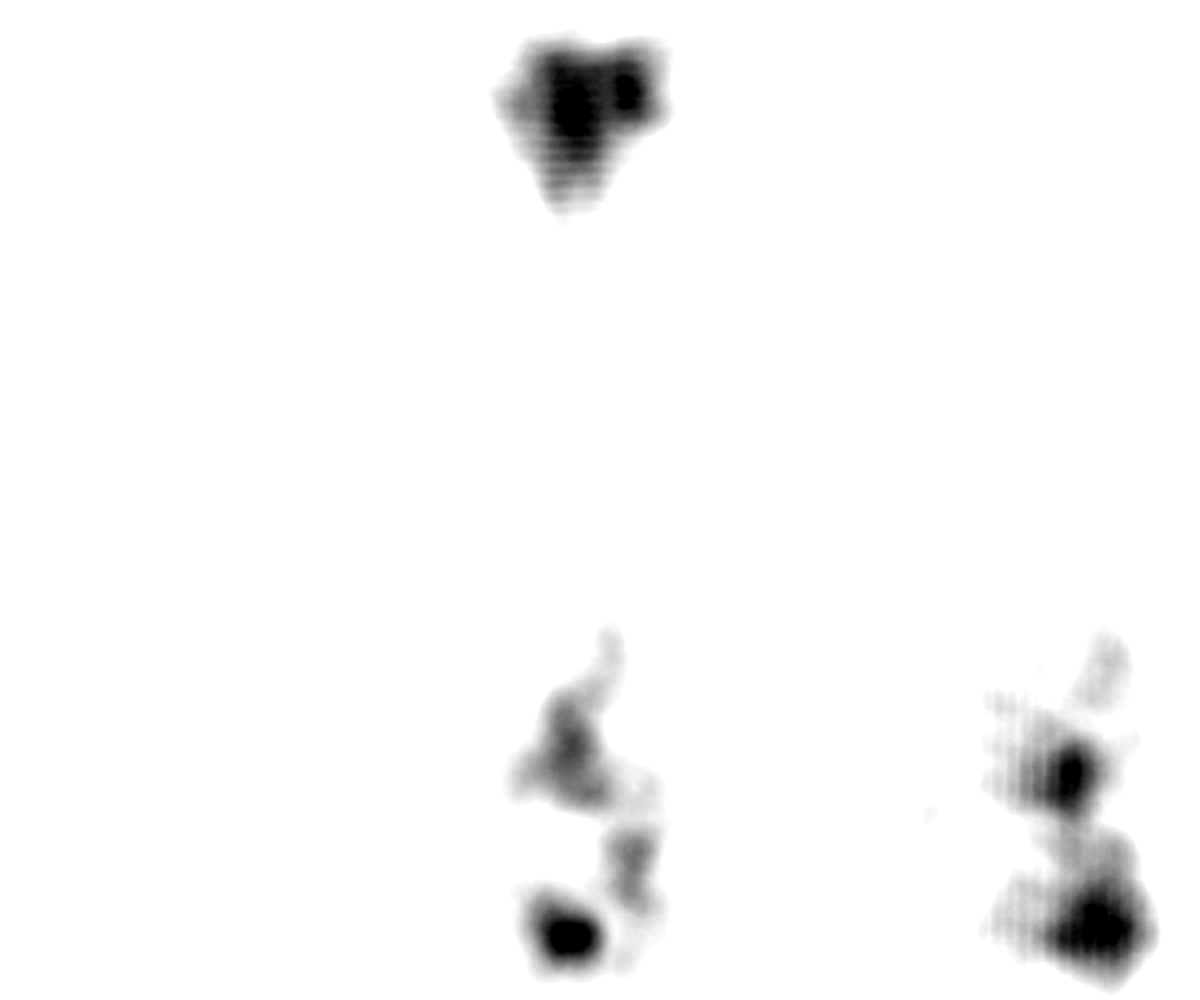

In [81]:
my_cmap = cm.gray
my_cmap.set_under('k', alpha=0)
i_volume = 2
# color_array = linear_cmap(np.array([0,0,0]),hex_to_rgb(primary_colors[i_volume]),n_bins=1000)
# color_array = ListedColormap(color_array[:,:])

volume = volumes[i_volume].copy()

fig = plt.figure(figsize=(12, 10),constrained_layout=True)
gs = fig.add_gridspec(nrows=3, ncols=3, width_ratios=[1,2,1], height_ratios=[.72,1,1])
ax1 = fig.add_subplot(gs[0,1])
ax1.imshow(np.flip(volume.sum(1),0),cmap="gray_r",alpha=1,
           vmin=np.percentile(np.unique(volume.sum(1)),20),
           vmax=np.percentile(np.unique(volume.sum(1)),90))
# ax1.imshow(y_proj[:,:,0] ,
#            interpolation=None,
#            cmap="gray_r",clim=[100, 260])
ax1.set_xticks([])
ax1.set_yticks([])

ax2 = fig.add_subplot(gs[1:,1])

ax2.imshow(volume[:,:,:].sum(0),cmap="gray_r",alpha=1,
           vmin=np.percentile(np.unique(volume.sum(0)),20),
           vmax=np.percentile(np.unique(volume.sum(0)),90))
# ax2.imshow(z_proj[:,:,0],
#            interpolation=None,alpha=1,vmax=None,
#            cmap="gray_r",clim=[100, 260])
ax2.set_xticks([])
ax2.set_yticks([])

ax3 = fig.add_subplot(gs[1:,2:])

ax3.imshow(np.rot90(np.flip(volume.sum(2),0),-1),cmap="gray_r",alpha=1,
           vmin=np.percentile(np.unique(volume.sum(2)),20),
           vmax=np.percentile(np.unique(volume.sum(2)),90))
# ax3.imshow(np.rot90(x_proj[:,:,0],-1),
#            interpolation=None,cmap="gray_r",clim=[100, 260],alpha=.3)
ax3.set_xticks([])
ax3.set_yticks([])
sns.despine(left=True,bottom=True)
plt.show()
# plt.savefig(r"C:\Users\epaoli\Desktop\new_figs\1_e.png",dpi=800)

In [72]:
mean_traces = []
for s_,e_ in zip(bins_[:-1],bins_[1:]):
    to_take = (np.argmax(turn_btas,1)>=s_)&(np.argmax(turn_btas,1)<e_)
    traces = turn_btas[to_take,:]
    mean_traces.append(np.array([np.nanmean(traces,0),sem(traces,0,nan_policy="omit")*1.23]).T)

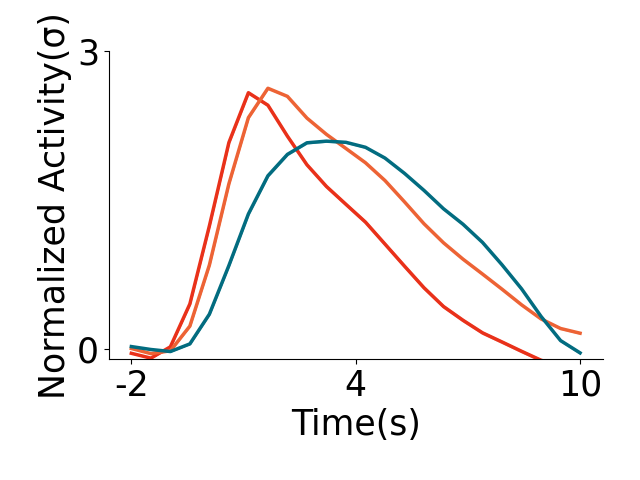

In [73]:
time_vector = np.linspace(0,24/2,24)
plt.figure()
for i in range(len(mean_traces)):
    plt.fill_between(time_vector,
                     mean_traces[i][:,0]-(mean_traces[i][:,1]/2),
                    mean_traces[i][:,0]+(mean_traces[i][:,1]/2),color=primary_colors[i],alpha=.5)
    plt.plot(time_vector,mean_traces[i][:,0],c=primary_colors[i],lw=2.5)
plt.ylabel("Normalized Activity(σ)",fontsize=25)
plt.xlabel("Time(s)",fontsize=25)
plt.xticks([0,6,12],[-2,4,10],fontsize=25)
plt.ylim([-0.1,3])
# plt.xlim([0,12])
plt.yticks([0,3],fontsize=25)

sns.despine()
plt.tight_layout()
plt.show()

In [34]:
data_to_plot = turn_btas[np.argsort(np.argmax(turn_btas,1)),:]
for i in range(data_to_plot.shape[0]):
    data_to_plot[i,:] = zscore(data_to_plot[i,:])

In [67]:
np.percentile(np.argmax(turn_btas,1),66)

9.0

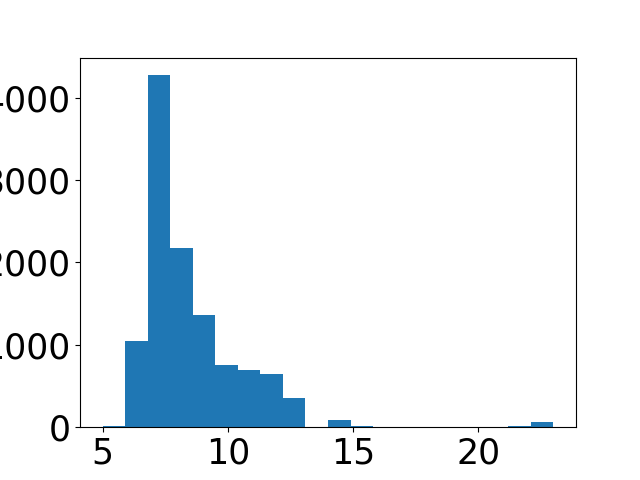

In [61]:
plt.figure()
plt.hist(np.argmax(turn_btas,1),20)
plt.show()

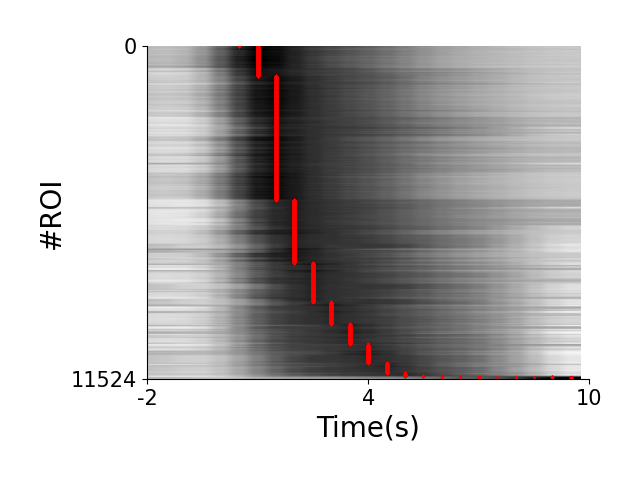

In [35]:
plt.figure()
plt.imshow(data_to_plot,
           cmap="gray_r",vmin=-2,vmax=2, aspect="auto",interpolation=None)
plt.scatter(np.argmax(turn_btas,1)[np.argsort(np.argmax(turn_btas,1))],
            np.arange(0,data_to_plot.shape[0]),c="r",s=2,alpha=.6)
plt.ylabel("#ROI",fontsize=20)
plt.xlabel("Time(s)",fontsize=20)
plt.xticks([0,12,24],[-2,4,10],fontsize=15)
plt.ylim([data_to_plot.shape[0],0])
plt.xlim([0,24])
plt.yticks([data_to_plot.shape[0],0],fontsize=15)

sns.despine()
plt.tight_layout()
plt.show()